# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/).

## Prepare the data

In [1]:
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
# !pip show torch
# !pip show torchvision

In [4]:
# Обработка изображений
import cv2
# Работа с путями в системе
from pathlib import Path
# Индикатор прогресса
from tqdm import tqdm_notebook
# import pandas as pd

from torch.utils.data import Dataset, random_split

In [5]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    HOME = Path('/content/gdrive/My Drive/dl/')
except:
    HOME = Path('./')

In [6]:
if torch.cuda.is_available():
    # работаем на GPU
    DEVICE = torch.device("cuda")
else:
    # работаем на CPU
    DEVICE = torch.device("cpu")
                        

### Глобальные настройки:

In [47]:
# Размеры изображения, оставил как в get_dataset.py - можно было подобрать, 
# но мне стало интерессно поработать именно с этим. 
# Например пришлось использовать размер ядра сверточного слоя (4,4), а не (3,3).
# Ядро (3,3) - влечет за собой добавления паддинга + не апсемплится на константу, 
# приходится указывать точный размер
IMAGE_H = 45
IMAGE_W = 45
N_CHANNELS = 3

# Размер изображения
INP_SIZE = IMAGE_H * IMAGE_W * N_CHANNELS
# Размер выхода скрытого слоя
HID_SIZE = 500
# Размер батча
BATCH_SIZE = 64

# Директории с изображениями
DIR_IMG = HOME.joinpath('../data/lfw-deepfunneled/')
# Изображения людей с улыбками
DIR_SMILE = HOME.joinpath('../data/smile/')
# Изображания людей без улыбок
DIR_USUAL = HOME.joinpath('../data/usual/')
# Техническая директория, для сохранния промежуточных результатов работы
DIR_STATE = HOME.joinpath('../data/state/')
# Директория с сохраненными весами моделей
DIR_LOAD = HOME.joinpath('../data/save_state/')

### Вспомогательные процедуры:

#### Загрузчик изображений

In [8]:
def image_loader(path):
    files = list(Path(path).rglob('*.jpg'))
    photos = np.zeros([len(files), IMAGE_H, IMAGE_W, N_CHANNELS])

    for i, fname in enumerate(tqdm_notebook(files)):
        
        # Читаем файл
        image = cv2.imread(str(fname))[80:-80,80:-80]
        # Меняем местами каналы, Изменяем размер, нормируем
        image = cv2.resize(image[..., [2,1,0]], (IMAGE_H, IMAGE_W)) / 255
        # Добавляем в список
        photos[i] = image

    # Меняем размерности с BHWC на BCHW
    photos = np.transpose(photos, (0,3,1,2))
    
    return photos.astype('float32')


#### Вывод изображений в виде миниатюр 
Парамерты:  
**images**: набор тензеров, для отображения  
**n_row**: количество строк  
**n_col**: количество столбцов  
**title**: заголовок  
**file_name**: имя файла для сохранения (набор не будет отображаться, проводится только сохранение)  


In [9]:
def plot_gallery(images, n_row=3, n_col=6, title=None, file_name=None):
    
    if isinstance(images, torch.Tensor):
        # Преобразуем тензор в массив numpy
        images = images.cpu().numpy()

    if images.shape[1] == N_CHANNELS and images.shape[3] == IMAGE_W:
        # Меняем размерности с BCHW на BHWC
        images = np.transpose(images, (0,2,3,1))

    """Helper function to plot a gallery of portraits"""
    fig, axs = plt.subplots(n_row, n_col, figsize=(1.5 * n_col, 1.7 * n_row))
    if title is not None:
        fig.suptitle(title)
    cnt = 0
    for i in range(n_row):
        for j in range(n_col):
            axs[i,j].imshow(images[cnt])
            axs[i,j].axis('off')
            cnt += 1
            
    if file_name is None:
        plt.show()
        pass
    else:
        fig.savefig(file_name)
        plt.close()

#### Сохранение весов модели
Парамерты:  
**model**: модель  
**losses**: массив со значениями лосов

In [72]:
def save_state(model, losses):
    # Имя файла
    train_loss = f"{losses[0,-1]:.4f}"
    val_loss = f"{losses[1,-1]:.4f}"
    epoch = f"{int(losses[2,-1]):0>4}"
    
    file_name = f"{model.name}_{epoch}_{train_loss}_{val_loss}"
    
    # Сохраняем модель
    torch.save(model.state_dict(), DIR_STATE.joinpath(file_name + ".pth"))

    # Сохраняем изображения
    model.eval()
    for batch in loader_val:
        batch = batch.to(DEVICE)
        with torch.no_grad(): 
            img = model(batch)
            if isinstance(img, tuple):
                img = img[-1]
            plot_gallery(img, 
                         title=f"epoch: {epoch} loss: {train_loss} val: {val_loss}", 
                         file_name=DIR_STATE.joinpath(file_name + ".jpg"))
        break
    model.train()


#### Лосс по валидационной выборке
Парамерты:  
**model**: модель  
**loss_f**: функция лосс  

In [11]:
def val_loss(model, loss_f):
    model.eval()
    
    for batch in loader_val:
        batch = batch.to(DEVICE)
        with torch.no_grad(): 
            output = model(batch)
            loss = loss_f(output, batch)
        break
        
    model.train()
    return loss.item()

#### Обучение модели  
Парамерты:  
**model**: модель  
**epoch**: оптимизатор  
**loss_f**: функция лосс  
**epochs**: количество эпох

In [12]:
def train_model(model, optimizer, loss_f, epochs):
    # Массив с лосами [[train loss], [val loss], [num epoch]]
    losses = np.array([[], [], []], dtype='float32')

    # Красивый прогресс бар
    pbar = tqdm_notebook(range(epochs), dynamic_ncols=True)

    for epoch in pbar:
        model.train()
        for batch in loader_train:
            batch = batch.to(DEVICE)

# ===================forward=====================
            optimizer.zero_grad()
        
            output = model(batch)
            loss = loss_f(output, batch)
            
# ===================backward====================
            loss.backward()
            optimizer.step()
        
# ===================log========================
        loss_v = val_loss(model, loss_f)
        pbar.set_description(f"loss: {loss.item():.4f} val: {loss_v:.4f}")

        losses = np.hstack((losses, [[loss.item()], [loss_v], [epoch]]))
    
        if (epoch % 5 == 0 or epoch == epochs - 1) or \
            losses[0].min() == losses[0, -1] or \
            losses[1].min() == losses[1, -1]:
            save_state(model, losses)
        
    return model, losses


#### Вывод результата декодирования

Парамерты:  
**model**: модель  

In [78]:
def show_enc_decode(model):
    model.eval()

    for batch in loader_val:
        batch = batch.to(DEVICE)
        with torch.no_grad(): 
            img = model(batch)
            if isinstance(img, tuple):
                img = img[-1]
            plot_gallery(batch, title="Оригинал")
            plot_gallery(img, title="Декодированное")
        break
    model.train()

#### Загрузчик весов модели  
Парамерты:  
**model**: модель  
**losses**: массив со значениями лосс  
**epoch**: номер эпохи для загрузки  
**file_name**: полный путь к файлу

In [14]:
def load_state(model, losses, epoch=None, file_name=None):
    if file_name is None:
        # Номер эпохи с минимальным валидационным лосом
        num = np.argmin(losses[1]) if epoch is None else np.where(losses[2] == epoch)[0][0]

        epoch = f"{int(losses[2,num]):0>4}"
        train_loss = f"{losses[0,num]:.4f}"
        val_loss = f"{losses[1,num]:.4f}"

        # Имя файла с весами
        state_file = f"{model.name}_{epoch}_{train_loss}_{val_loss}.pth"
        state_file = DIR_STATE.joinpath(state_file)
    else:
        state_file = file_name


    model.load_state_dict(torch.load(state_file))
    model.eval()
    print(f"load file: {state_file}")
    
    return model


#### График лосов
Парамерты:  
**losses**: массив со значениями лосс  
**title**: Заголовок графика

In [15]:
def loss_graph(losses, title=None):
    plt.plot(losses[2].astype('int32'), losses[0], label='Training loss')
    plt.plot(losses[2].astype('int32'), losses[1], label='Validation loss')
    if title is not None:
        plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#### Распределение вывода энкодера (PCA, t-SNE)
Парамерты:  
**losses**: вектор, полученный на выходе скрытого слоя

In [16]:
def distribution(data):
    x_pca = PCA(n_components=2)
    x_tsne = TSNE(n_components=2)

    x_pca = x_pca.fit_transform(data)

    fig, ax = plt.subplots()
    plt.plot(x_pca[:,0], x_pca[:,1], 'o')
    plt.title("PCA")
    plt.show()

    x_tsne = x_tsne.fit_transform(data)

    fig, ax = plt.subplots()
    plt.plot(x_tsne[:,0], x_tsne[:,1], 'o')
    plt.title("t-SNE")
    plt.show()

#### Вектор после энкодера
Парамерты:  
**model**: модель  
**loader**: генератор/итеретор изображений  
**data**: тензор для добавления данных  

In [17]:
def hide_vector(model, loader, data):
    model.eval()
    for batch in loader:
        with torch.no_grad(): 
            batch = batch.to(DEVICE)
            vector = model.encode(batch)
            data = torch.cat((data, vector.cpu().detach()), dim=0)
        
    return data.reshape([data.shape[0], -1])

#### Модификация изображений
Парамерты:  
**model**: модель  
**loader**: генератор/итеретор изображений  
**vector**: тензор с "модификацией"  

In [18]:
def img_modify(model, loader, vector):
    model.eval()

    for batch in loader:
        with torch.no_grad(): 
            batch = batch.to(DEVICE)
        
            encode_l = model.encode(batch)
            # Добавляем вектор
            edit_img = encode_l + vector[None,:].repeat_interleave(len(encode_l),0).to(DEVICE)
            # Получаем модефицированное изображение
            edit_img = model.decode(edit_img)
            
            # Восстанавливаем изображение
            decode_img = model.decode(encode_l)
        
    for img in loader_usual:
        plot_gallery(img, n_row=2, n_col=10, title="Оригинал")
    
    plot_gallery(decode_img,n_row=2, n_col=10, title="Реконструкция")
    plot_gallery(edit_img,n_row=2, n_col=10, title="Модификация")


### Датасеты
#### Основное хранилище изображений

In [19]:
dataset = image_loader(DIR_IMG)

In [20]:
# Определяем размер выборки
TRAIN_SIZE = len(dataset) * 80 // 100
VAL_SIZE = len(dataset) - TRAIN_SIZE
print("Тренировочная:", TRAIN_SIZE)
print("Валидационная:", VAL_SIZE)

# Разбиваем на 2 выборки
loader_train, loader_val = random_split(dataset, lengths=[TRAIN_SIZE, VAL_SIZE])

# Модифицируем даталоадеры
loader_train = DataLoader(loader_train, batch_size=BATCH_SIZE, shuffle=True)
loader_val = DataLoader(loader_val, batch_size=BATCH_SIZE, shuffle=False)


Тренировочная: 10586
Валидационная: 2647


#### Набор изображений с улыбкой

In [21]:
loader_smile = DataLoader(image_loader(DIR_SMILE), batch_size=BATCH_SIZE, shuffle=False)

#### Набор изображений без улыбки

In [22]:
loader_usual = DataLoader(image_loader(DIR_USUAL), batch_size=BATCH_SIZE, shuffle=False)

### Вспомогательные классы

In [23]:
# 3D массив в 1D
class Flattern(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

# 1D массив в 3D
class UnFlattern(nn.Module):
    def __init__(self, param):
        super().__init__()
        self.param = param

    def forward(self, x):
        return x.view(x.shape[0], *self.param)


# Autoencoder

### Реализуем 2 архитеткуры:
#### 1. Полносвязанный автоэнкодер

In [24]:
class FullAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.name_ = 'FullAE'
        
        count_01 = 2048
        count_02 = 1024 + 512
        count_03 = 1024

        # Енкодер
        self.f_enc = nn.Sequential(
            Flattern(),
            nn.Linear(INP_SIZE , count_01),
            nn.ReLU(),
            nn.Linear(count_01, count_02),
            nn.ReLU(), 
            nn.Linear(count_02, HID_SIZE),
            nn.ReLU(), 
        )
        
        # Декодер
        self.f_dec = nn.Sequential(
            nn.Linear(HID_SIZE, count_02),
            nn.ReLU(),
            nn.Linear(count_02, count_01),
            nn.ReLU(), 
            nn.Linear(count_01, INP_SIZE), 
            nn.Sigmoid(),
            UnFlattern((N_CHANNELS, IMAGE_H, IMAGE_W)),
        )
        
    @property
    def name(self):
        return self.name_

    def encode(self, x):
        return self.f_enc(x)
    
    def decode(self, z):
        return self.f_dec(z)
    
    def forward(self, x, prn_shape=False):
        if prn_shape:
            print("input:", x.shape)

        latent_code = self.encode(x) 
        if prn_shape:
            print("latent_code:", latent_code.shape)
    
        reconstruction = self.decode(latent_code)
        if prn_shape:
            print("reconstruction:", reconstruction.shape)

        return reconstruction


#### 2. Сверточный автоэнкодер

In [429]:
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.name_ = 'ConvAE'
        
        count_01 = 256
        count_02 = 128
        count_03 = 32
        
        # Енкодер
        self.f_enc = nn.Sequential(
            nn.Conv2d(in_channels=N_CHANNELS, out_channels=count_01, kernel_size=4),
            nn.ReLU(),
            nn.BatchNorm2d(count_01), 

            nn.MaxPool2d(kernel_size=2), 
            nn.Dropout(p=0.3),

            nn.Conv2d(in_channels=count_01, out_channels=count_02, kernel_size=4),
            nn.ReLU(), 
            nn.BatchNorm2d(count_02),
            
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.3),

            nn.Conv2d(in_channels=count_02, out_channels=count_03, kernel_size=4),
            nn.ReLU(), 
            nn.BatchNorm2d(count_03),
        )
        
        # Декодер
        self.f_dec = nn.Sequential(
            nn.ConvTranspose2d(in_channels=count_03, out_channels=count_02, kernel_size=4), 
            nn.ReLU(),
            nn.BatchNorm2d(count_02),

            nn.UpsamplingBilinear2d(scale_factor=2),
            
            nn.ConvTranspose2d(in_channels=count_02, out_channels=count_01, kernel_size=4), 
            nn.ReLU(),
            nn.BatchNorm2d(count_01),

            nn.UpsamplingBilinear2d(scale_factor=2),

            nn.ConvTranspose2d(in_channels=count_01, out_channels=N_CHANNELS, kernel_size=4),
            nn.Sigmoid(),

        )
    
    @property
    def name(self):
        return self.name_
    
    def encode(self, x):
        return self.f_enc(x)
    
    def decode(self, z):
        return self.f_dec(z)
    
    def forward(self, x, prn_shape=False):
        if prn_shape:
            print("input:", x.shape)

        latent_code = self.encode(x) 
        if prn_shape:
            print("latent_code:", latent_code.shape)
    
        reconstruction = self.decode(latent_code)
        if prn_shape:
            print("reconstruction:", reconstruction.shape)

        return reconstruction


### Обучим и посмотрим результаты обучения
#### Полносвязанный автоэнкодер

In [414]:
model1 = FullAE().to(DEVICE)

optimizer = torch.optim.Adam(model1.parameters())
loss = nn.MSELoss().to(DEVICE)

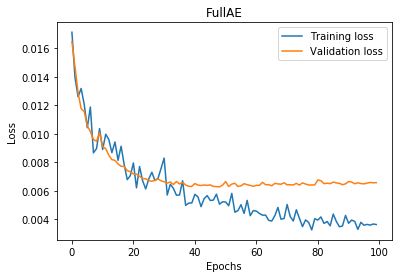

In [27]:
# Обучаем
model1, losses1 = train_model(model1, optimizer, loss, 100)
# Рисуем графики лосов
loss_graph(losses1, title=model1.name)

In [425]:
# Загружаем веса модели с лучшим валидационным лосом
# model1 = load_state(model1, losses1)
model1 = load_state(model1, 
                    None, 
                    file_name=DIR_LOAD.joinpath("FullAE_0048_0.0051_0.0063.pth"))


load file: ..\data\save_state\FullAE_0048_0.0051_0.0063.pth


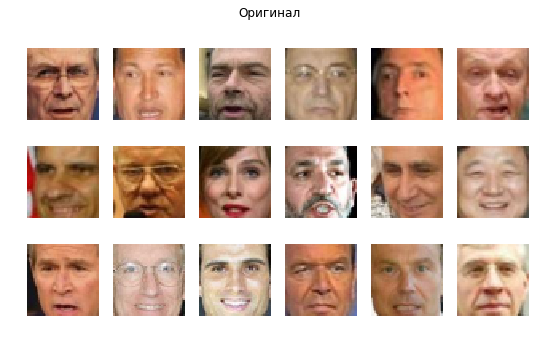

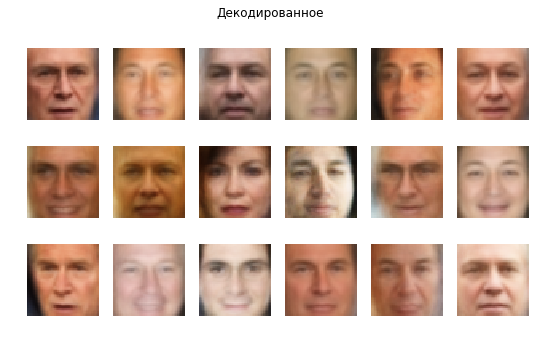

In [29]:
# Отображаем работу энкодера
show_enc_decode(model1)

#### Сверточный автоэнкодер

In [430]:
model2 = ConvAE().to(DEVICE)

optimizer = torch.optim.Adam(model2.parameters())
loss = nn.MSELoss().to(DEVICE)

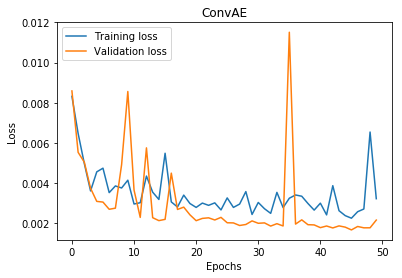

In [31]:
# Обучаем
model2, losses2 = train_model(model2, optimizer, loss, 50)
# Рисуем графики лосов
loss_graph(losses2, title=model2.name)

In [431]:
# Загружаем веса модели с лучшим валидационным лосом
# model2 = load_state(model2, losses2)
model2 = load_state(model2, 
                    None, 
                    file_name=DIR_LOAD.joinpath("ConvAE_0045_0.0022_0.0017.pth"))


load file: ..\data\save_state\ConvAE_0045_0.0022_0.0017.pth


# Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### Полносвязанный автоэнкодер

In [333]:
# Множители добавлены после того как посмотрел результат распределения 
# выборки с помощью PCA, t-SNE

# 1. Получаем выход со скрытого слоя
data = torch.zeros((0, HID_SIZE))
data = hide_vector(model1, loader_train, data)
data = hide_vector(model1, loader_val, data)
z_mean = data.numpy().mean(axis=0)
z_std = np.std(data.numpy(), axis=0)

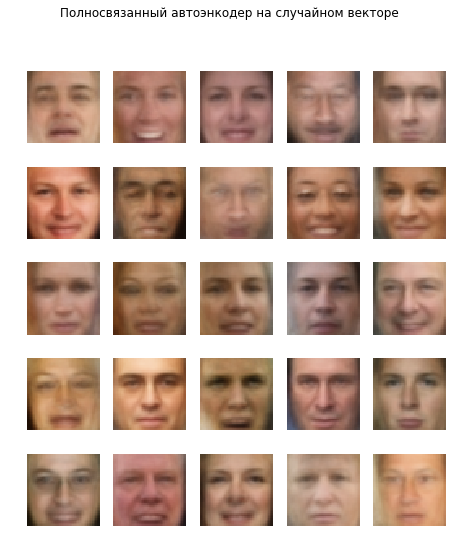

In [332]:
# 2. Генерируем 25 рандомных векторов размера latent_space
rnd_tensor = np.random.randn(25, HID_SIZE) * z_std + z_mean
rnd_tensor = torch.from_numpy(rnd_tensor.astype('float32')).to(DEVICE)

model1.eval()
with torch.no_grad(): 
    img = model1.decode(rnd_tensor)

plot_gallery(img, n_row=5, n_col=5, title="Полносвязанный автоэнкодер на случайном векторе")

#### Сверточный автоэнкодер

In [357]:
# 1. Получаем выход со скрытого слоя
data = torch.zeros((0, 32, 6, 6))
data = hide_vector(model2, loader_train, data)
data = hide_vector(model2, loader_val, data.reshape(-1, 32, 6, 6))
z_mean = data.numpy().mean(axis=0).reshape(32, 6, 6)
z_std = np.std(data.numpy(), axis=0).reshape(32, 6, 6)

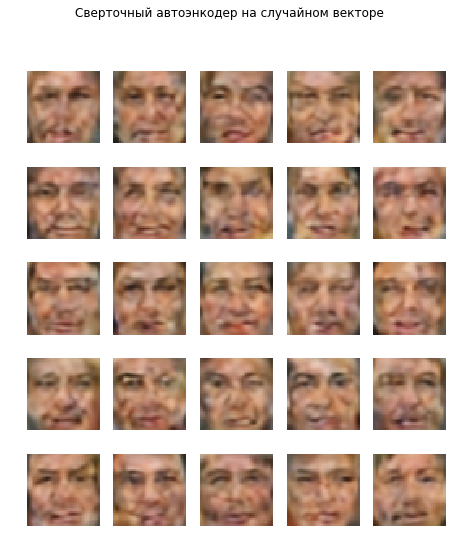

In [362]:
# 2. Генерируем 25 рандомных векторов размера latent_space
rnd_tensor = np.random.randn(25, 32, 6, 6) * z_std + z_mean
rnd_tensor = torch.from_numpy(rnd_tensor.astype('float32')).to(DEVICE)

model2.eval()
with torch.no_grad(): 
    img = model2.decode(rnd_tensor)

plot_gallery(img, n_row=5, n_col=5, title="Сверточный автоэнкодер на случайном векторе")

### Структура латентного вектора

Cверточный не смог сгененрировать лица при нормальном распределении, посмотрим распределение на выходе энкодера.  
Выделим 2 главные компоненты из вектора энкодреа, с помощья PCA, t-SNE и отобразим на графике полученные распределения

#### Полносвязанный автоэнкодер

In [220]:
data = torch.zeros((0, HID_SIZE))
data = hide_vector(model1, loader_train, data)

FullAE


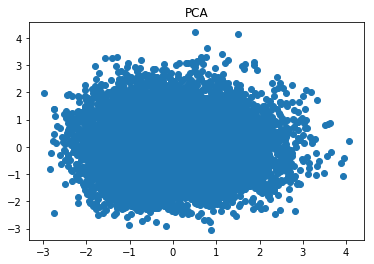

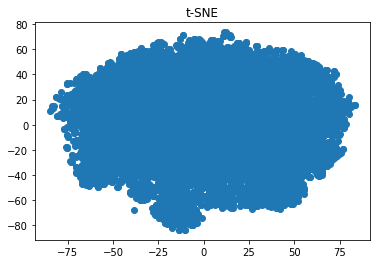

In [37]:
print(model1.name)
distribution(data)

#### Сверточный автоэнкодер

In [192]:
data = torch.zeros((0, 32, 6, 6))
data = hide_vector(model2, loader_train, data)

ConvAE


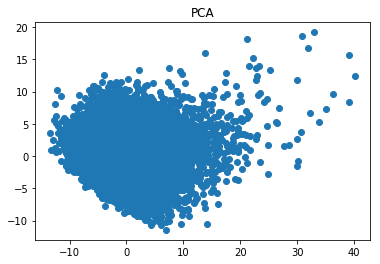

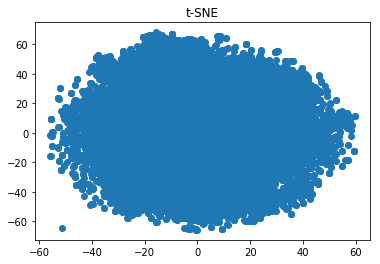

In [39]:
print(model2.name)
distribution(data)

# Модификация изображений
Попробуем пририсовывать людям улыбки

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

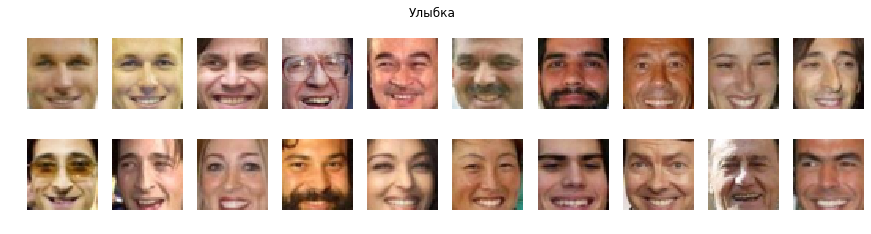

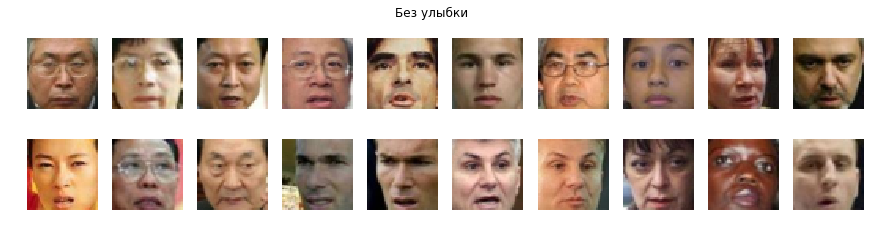

In [40]:
for img in loader_smile:
    plot_gallery(img, n_row=2, n_col=10, title="Улыбка")
    
for img in loader_usual:
    plot_gallery(img,n_row=2, n_col=10, title="Без улыбки")

#### Полносвязанный автоэнкодер

In [41]:
data = torch.zeros((0, HID_SIZE))

# Среднее значение улыбающихся людей
smile_v = hide_vector(model1, loader_smile, data).mean(dim=0)
# Среднее значение обычных людей
usual_v = hide_vector(model1, loader_usual, data).mean(dim=0)

# Вектор улыбки
shift_vector =  smile_v - usual_v

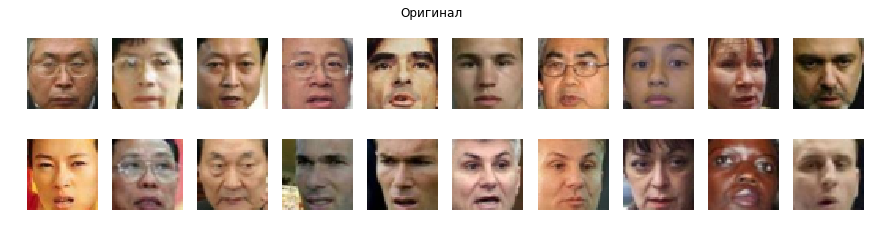

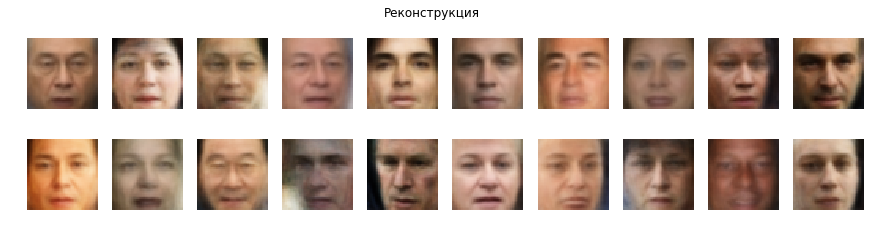

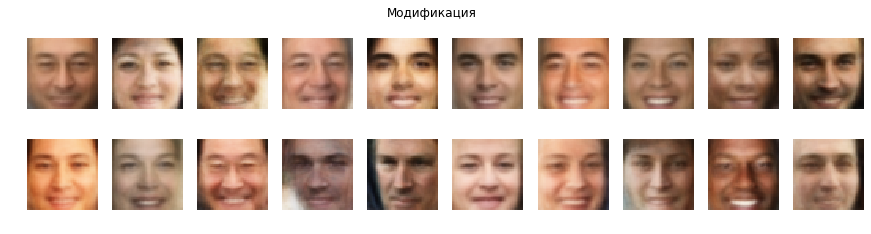

In [42]:
img_modify(model1, loader_usual, shift_vector)

#### Сверточный автоэнкодер

In [43]:
data = torch.zeros((0, 32, 6, 6))

# Среднее значение улыбающихся людей
smile_v = hide_vector(model2, loader_smile, data).mean(dim=0)
# Среднее значение обычных людей
usual_v = hide_vector(model2, loader_usual, data).mean(dim=0)

# Вектор улыбки
shift_vector =  (smile_v - usual_v).view(32, 6, 6)

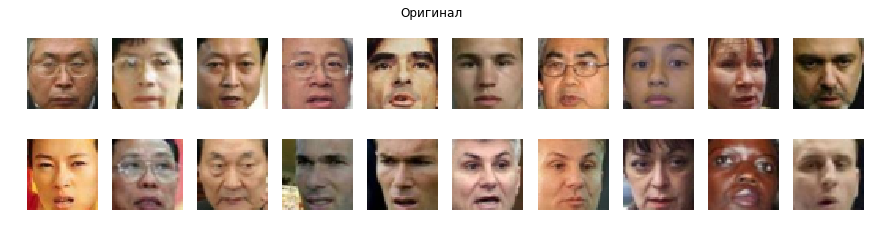

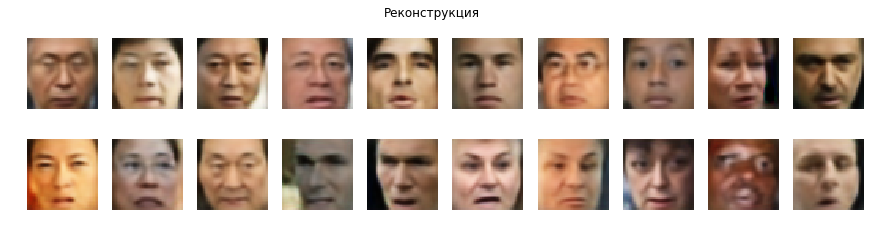

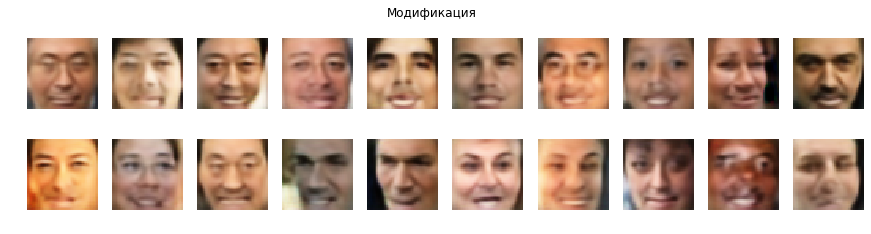

In [45]:
img_modify(model2, loader_usual, shift_vector)

# BONUS 1. 
### Variational Autoencoder

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

#### Определяем функцию лосс

In [68]:
# Добавляем множитель BCE_MUL, без него обучение стоит на месте. 
# Изменяя BCE_MUL и lr можно проводить настройку обучения

BCE_MUL = 1_000_000
lr=1e-4

def loss_vae(z, x):
    mu, logsigma, reconstruction = z
    
    x = x.view(-1, INP_SIZE).to(DEVICE)
    reconstruction = reconstruction.view(-1, INP_SIZE).to(DEVICE)

    if reconstruction.min() < 0 or reconstruction.max() > 1:
        print("reconstruction")
    if x.min() < 0 or x.max() > 1:
        print("reconstruction")
    
    BCE = F.binary_cross_entropy(reconstruction, x)
    BCE = BCE.mul(BCE_MUL)
    
    KLD = (1 + 2 * logsigma - mu.pow(2) - logsigma.exp().pow(2))
    KLD = -0.5 * KLD.sum(dim=1).mean()
    
    if torch.isnan(KLD) or torch.isnan(BCE):
        print(logsigma)
        print(mu.pow(2))
        print(logsigma.exp().pow(2))
        
    return BCE + KLD


### Реализуем 2 архитеткуры:
#### 1. Полносвязанный автоэнкодер

In [70]:
class FullVAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.name_ = "FullVAE"
        self.mu_ = torch.Tensor(0)
        self.logvar_ = torch.Tensor(0)
        
        count_01 = 2048
        count_02 = 1024 + 512
        count_03 = 1024

        # Енкодер
        self.f_enc = nn.Sequential(
            Flattern(),
            nn.Linear(INP_SIZE, count_01),
            nn.ReLU(),
            nn.Linear(count_01, count_02),
            nn.ReLU(), 
        )

        # Матожидание
        self.f_mu = nn.Sequential(
            nn.Linear(count_02, count_03),
            nn.ReLU(), 
            nn.Linear(count_03, HID_SIZE),
        )
            
        # Дисперсия
        self.f_logvar = nn.Sequential(
            nn.Linear(count_02, count_03),
            nn.ReLU(), 
            nn.Linear(count_03, HID_SIZE),
        )
        
        # Декодер
        self.f_dec = nn.Sequential(
            nn.Linear(HID_SIZE, count_03),
            nn.ReLU(),
            nn.Linear(count_03, count_02),
            nn.ReLU(), 
            nn.Linear(count_02, count_01),
            nn.ReLU(), 

            nn.Linear(count_01, INP_SIZE),
            nn.Sigmoid(),
            UnFlattern((N_CHANNELS, IMAGE_H, IMAGE_W)),
        )
        
    @property
    def name(self):
        return self.name_
    
    @property
    def mu(self):
        return self.mu_
    
    @property
    def logvar(self):
        return self.logvar_
    
    def encode(self, x):
        x = self.f_enc(x)

        self.mu_ = self.f_mu(x)
        self.logvar_ = self.f_logvar(x)

        return self.reparameterize()
    
    def reparameterize(self):
        if self.training:
            std = self.logvar_.exp_()
            eps = torch.zeros_like(std).normal_()
            return eps.mul(std).add_(self.mu_)
        else:
            return self.mu_
   
    def decode(self, z):
        return self.f_dec(z)

    def forward(self, x, prn_shape=False):

        if prn_shape:
            print("input:", x.shape)
            
        latent_code = self.encode(x)
        if prn_shape:
            print("latent_code:", latent_code.shape)
            
        reconstruction = self.decode(latent_code)
        if prn_shape:
            print("reconstruction:", reconstruction.shape)

        return self.mu_, self.logvar_, reconstruction



In [74]:
model3 = FullVAE().to(DEVICE)
optimizer = torch.optim.Adam(model3.parameters(), lr=lr)

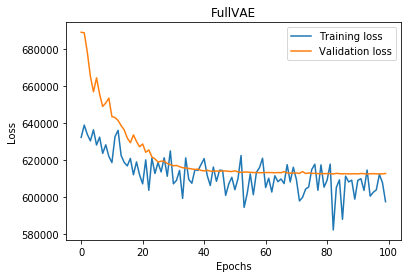

In [75]:
# Обучаем
model3, losses3 = train_model(model3, optimizer, loss_vae, 100)
# Рисуем графики лосов
loss_graph(losses3, title=model3.name)

In [432]:
# Загружаем веса модели с лучшим валидационным лосом
# model3 = load_state(model3, losses3)
model3 = load_state(model3, 
                    None, 
                    file_name=DIR_LOAD.joinpath("FullVAE_0093_614573.3125_612399.5000.pth"))


load file: ..\data\save_state\FullVAE_0093_614573.3125_612399.5000.pth


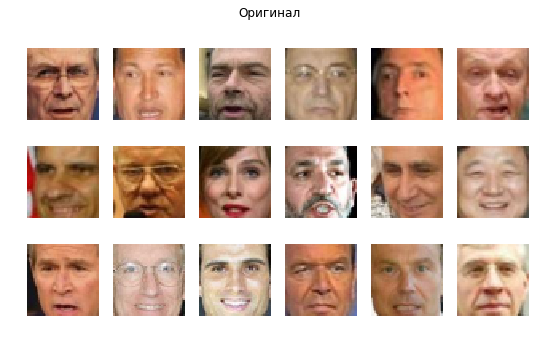

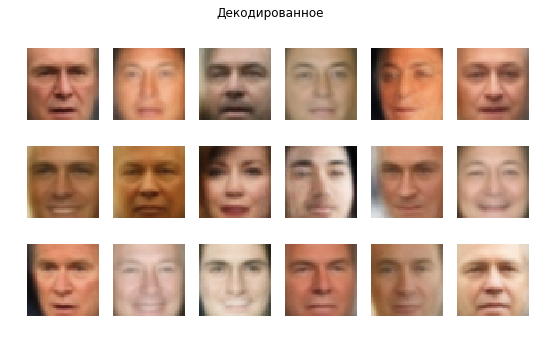

In [79]:
# Отображаем работу энкодера
show_enc_decode(model3)

#### 2. Сверточный автоэнкодер

In [410]:
class ConvVAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.name_ = 'ConvVAE'
        
        count_01 = 256
        count_02 = 128
        count_03 = 64
        
        num_03 = count_03 * 6 * 6
        
        # Енкодер
        self.f_enc = nn.Sequential(
            nn.Conv2d(in_channels=N_CHANNELS, out_channels=count_01, kernel_size=4),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2), 
            nn.Dropout(p=0.3),

            nn.Conv2d(in_channels=count_01, out_channels=count_02, kernel_size=4),
            nn.ReLU(), 
            
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.3),

            nn.Conv2d(in_channels=count_02, out_channels=count_03, kernel_size=4),
            nn.ReLU(), 

            Flattern(),
        )
        
        # Матожидание
        self.f_mu = nn.Sequential(
            nn.Linear(num_03, HID_SIZE), 
            )
            
        # Дисперсия
        self.f_logvar = nn.Sequential(
            nn.Linear(num_03, HID_SIZE), 
            )
        
        # Декодер
        self.f_dec = nn.Sequential(
            nn.Linear(HID_SIZE, num_03), 
            nn.ReLU(), 
            UnFlattern((count_03, 6, 6)),

            nn.ConvTranspose2d(in_channels=count_03, out_channels=count_02, kernel_size=4), 
            nn.ReLU(),

            nn.UpsamplingBilinear2d(scale_factor=2),
            
            nn.ConvTranspose2d(in_channels=count_02, out_channels=count_01, kernel_size=4), 
            nn.ReLU(),

            nn.UpsamplingBilinear2d(scale_factor=2),

            nn.ConvTranspose2d(in_channels=count_01, out_channels=N_CHANNELS, kernel_size=4),
            nn.Sigmoid(),
        )
        
    @property
    def name(self):
        return self.name_
    
    @property
    def mu(self):
        return self.mu_
    
    @property
    def logvar(self):
        return self.logvar_
    
    def encode(self, x):
        x = self.f_enc(x)

        self.mu_ = self.f_mu(x)
        self.logvar_ = self.f_logvar(x)

        return self.reparameterize()
    
    def reparameterize(self):
        if self.training:
            std = self.logvar_.exp_()
            eps = torch.zeros_like(std).normal_()
            return eps.mul(std).add_(self.mu_)
        else:
            return self.mu_
   
    def decode(self, z):
        return self.f_dec(z)

    def forward(self, x, prn_shape=False):

        if prn_shape:
            print("input:", x.shape)
            
        latent_code = self.encode(x)
        if prn_shape:
            print("latent_code:", latent_code.shape)
            
        reconstruction = self.decode(latent_code)
        if prn_shape:
            print("reconstruction:", reconstruction.shape)

        return self.mu_, self.logvar_, reconstruction
    

In [397]:
model4 = ConvVAE().to(DEVICE)
optimizer = torch.optim.Adam(model4.parameters(), lr=lr)

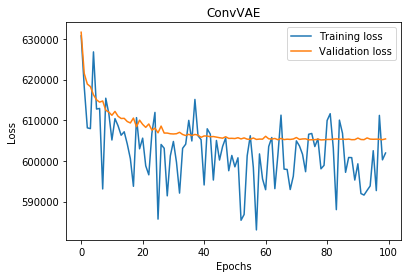

In [398]:
# Обучаем
model4, losses4 = train_model(model4, optimizer, loss_vae, 100)
# Рисуем графики лосов
loss_graph(losses4, title=model4.name)

In [433]:
# Загружаем веса модели с лучшим валидационным лосом
# model4 = load_state(model4, losses4)
model4 = load_state(model4, 
                    None, 
                    file_name=DIR_LOAD.joinpath("ConvVAE_0078_598061.8125_605159.3125.pth"))


load file: ..\data\save_state\ConvVAE_0078_598061.8125_605159.3125.pth


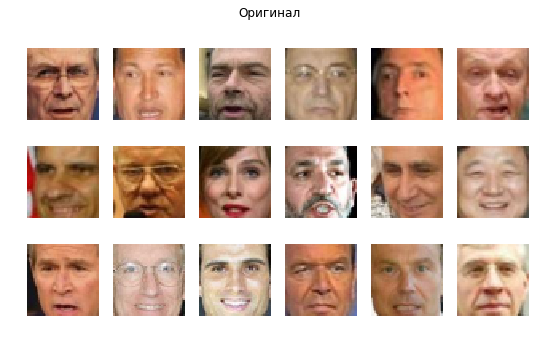

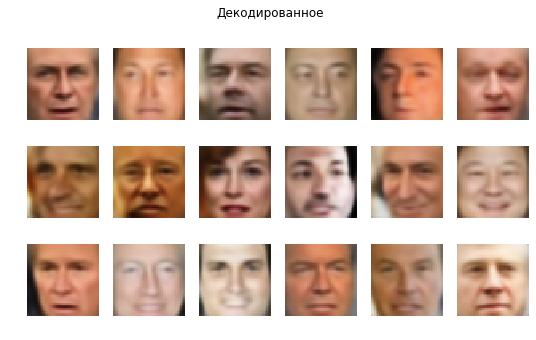

In [412]:
# Отображаем работу энкодера
show_enc_decode(model4)

# Sampling

#### Полносвязанный VAE

In [374]:
# 1. Получаем выход со скрытого слоя
data = torch.zeros((0, HID_SIZE))
data = hide_vector(model3, loader_train, data)
data = hide_vector(model3, loader_val, data)
z_mean = data.numpy().mean(axis=0)
z_std = np.std(data.numpy(), axis=0)

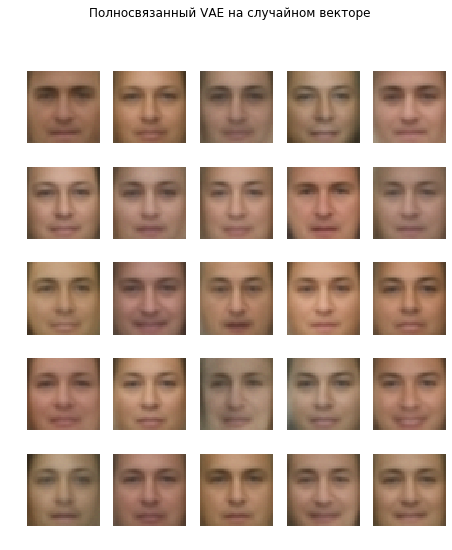

In [382]:
# 2. Генерируем 25 рандомных векторов размера latent_space
rnd_tensor = np.random.randn(25, HID_SIZE) * z_std + z_mean
rnd_tensor = torch.from_numpy(rnd_tensor.astype('float32')).to(DEVICE)

model3.eval()
with torch.no_grad(): 
    img = model3.decode(rnd_tensor)

plot_gallery(img, n_row=5, n_col=5, title="Полносвязанный VAE на случайном векторе")


#### Сверточный VAE

In [401]:
# 1. Получаем выход со скрытого слоя
data = torch.zeros((0, HID_SIZE))
data = hide_vector(model4, loader_train, data)
data = hide_vector(model4, loader_val, data)
z_mean = data.numpy().mean(axis=0)
z_std = np.std(data.numpy(), axis=0)

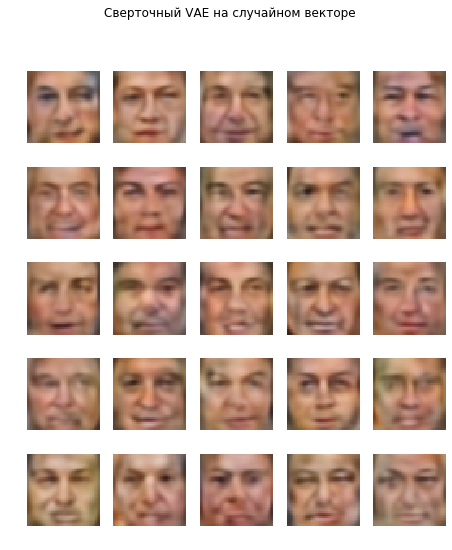

In [409]:
# 2. Генерируем 25 рандомных векторов размера latent_space
rnd_tensor = np.random.randn(25, HID_SIZE) * z_std + z_mean
rnd_tensor = torch.from_numpy(rnd_tensor.astype('float32')).to(DEVICE)

model4.eval()
with torch.no_grad(): 
    img = model4.decode(rnd_tensor)

plot_gallery(img, n_row=5, n_col=5, title="Сверточный VAE на случайном векторе")

### Структура латентного вектора

#### Полносвязанный VAE

In [386]:
data = torch.zeros((0, HID_SIZE))
data = hide_vector(model3, loader_train, data)

FullVAE


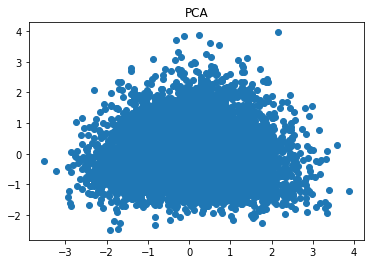

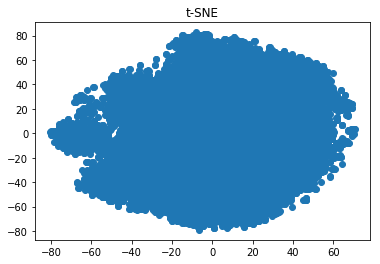

In [387]:
print(model3.name)
distribution(data)

#### Сверточный VAE

In [403]:
data = torch.zeros((0, HID_SIZE))
data = hide_vector(model4, loader_train, data)

ConvVAE


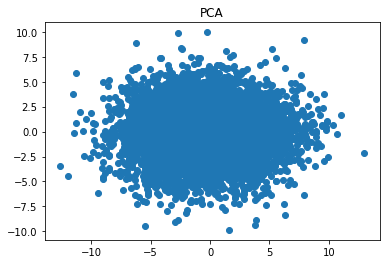

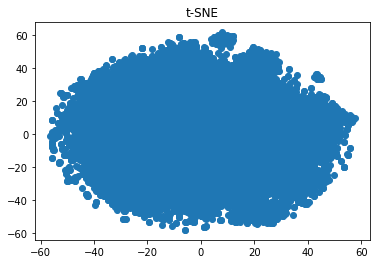

In [404]:
print(model4.name)
distribution(data)

# Модификация изображений
Попробуем пририсовывать людям улыбки

#### Полносвязанный вариационный автоэнкодер

In [390]:
data = torch.zeros((0, HID_SIZE))

# Среднее значение улыбающихся людей
smile_v = hide_vector(model3, loader_smile, data).mean(dim=0)
# Среднее значение обычных людей
usual_v = hide_vector(model3, loader_usual, data).mean(dim=0)

# Вектор улыбки
shift_vector =  smile_v - usual_v

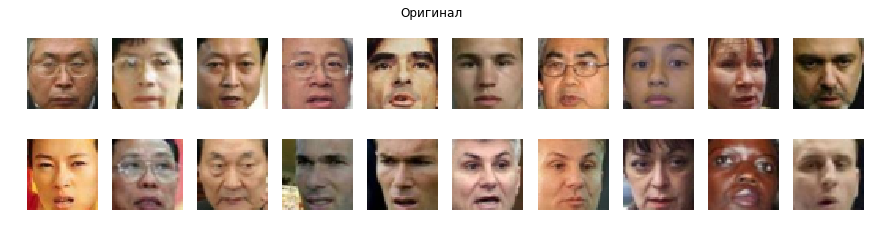

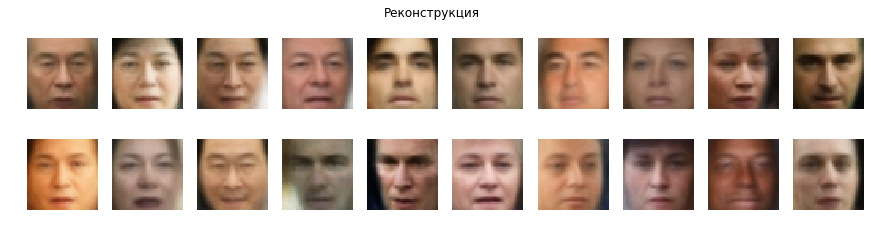

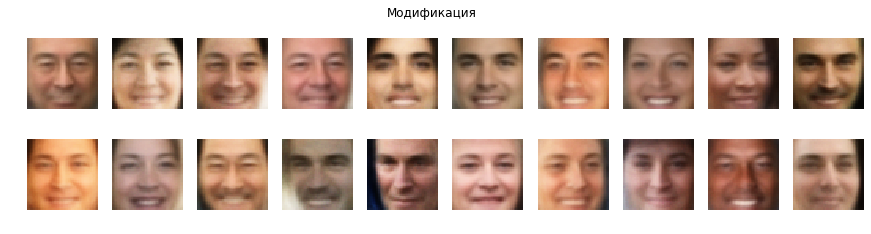

In [391]:
img_modify(model3, loader_usual, shift_vector)

#### Сверточный вариационный автоэнкодер

In [405]:
data = torch.zeros((0, HID_SIZE))

# Среднее значение улыбающихся людей
smile_v = hide_vector(model4, loader_smile, data).mean(dim=0)
# Среднее значение обычных людей
usual_v = hide_vector(model4, loader_usual, data).mean(dim=0)

# Вектор улыбки
shift_vector =  (smile_v - usual_v)

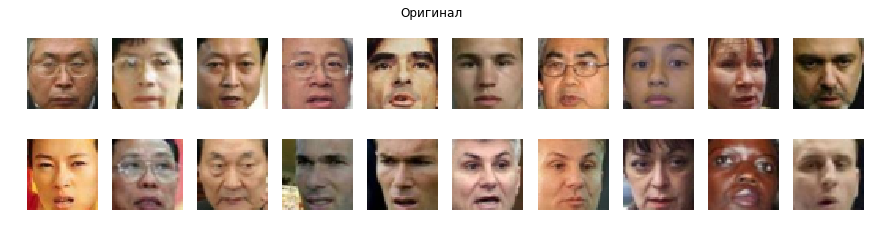

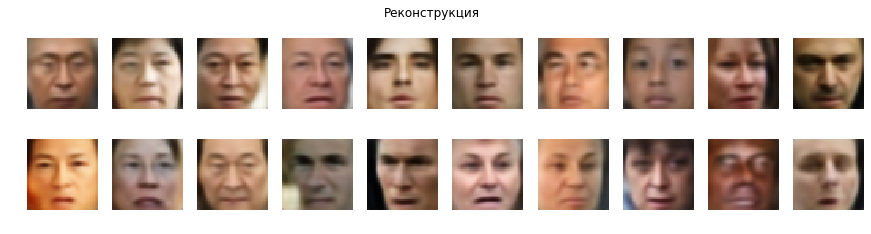

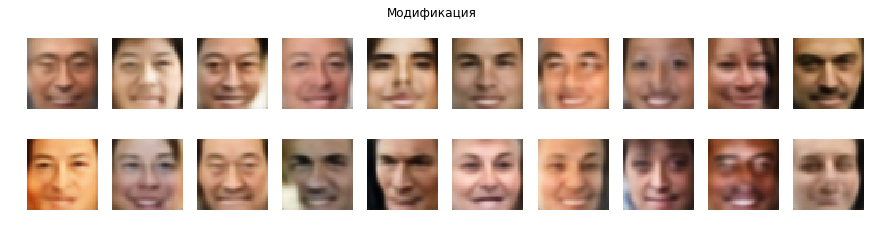

In [406]:
img_modify(model4, loader_usual, shift_vector)